# 0. Configuración de entorno

In [1]:
%pip install pandas scikit-learn nltk matplotlib seaborn openpyxl nltk -q
#!python -m spacy download es_core_news_lg -q


Note: you may need to restart the kernel to use updated packages.


In [2]:

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Preprocesamiento y features
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelado y algoritmos
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model selection
from sklearn.model_selection import (
    train_test_split, GridSearchCV
)

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix

import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

from sklearn.base import clone
from collections import Counter



dict_ods = {
    1: "Fin de la pobreza",
    3: "Salud y bienestar",
    4: "Educación de calidad",
}


In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1. Documentación del aprendizaje automático
[Canvas](../docs/canvas.docx)

# 2. Entendimiento y preparación de datos
## 2.1 Carga de datos

In [4]:
df_test = pd.read_excel('../data/Datos de prueba_proyecto.xlsx')
df = pd.read_excel('../data/Datos_proyecto.xlsx')

In [5]:
x,y = df.shape
print(f'El dataset tiene {x} filas (opiniones)')

El dataset tiene 2424 filas (opiniones)


## 2.2 Distribución de datos

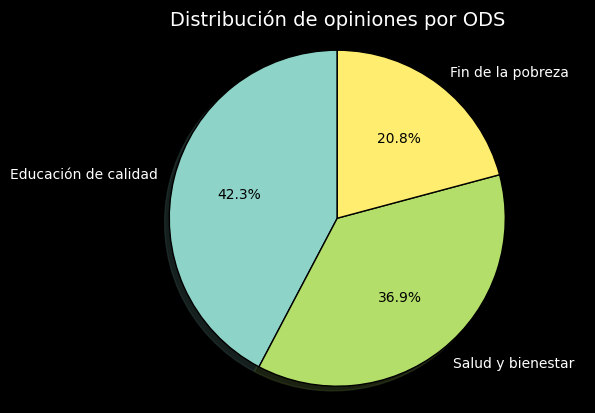

In [6]:
label_counts = df['labels'].value_counts()
label_counts.index = label_counts.index.map(dict_ods)

plt.figure(facecolor='black')  
ax = label_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    cmap='Set3',
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    textprops={'color': 'white'}
)

ax.set_facecolor('black')
plt.title("Distribución de opiniones por ODS", color='white', fontsize=14)
plt.ylabel("")
plt.axis("equal")

for text in ax.texts:
    if "%" in text.get_text():  
        text.set_color("black")

plt.show()


## 2.3 Valores nulos y repetidos

In [7]:
nulos = df.isnull().sum()

print("Valores nulos por columna:")
print(nulos)

Valores nulos por columna:
textos    0
labels    0
dtype: int64


In [8]:
print("Opiniones repetidas:", (df['textos'].value_counts()>1).sum())

Opiniones repetidas: 0


## 2.4 Longitud de opiniones

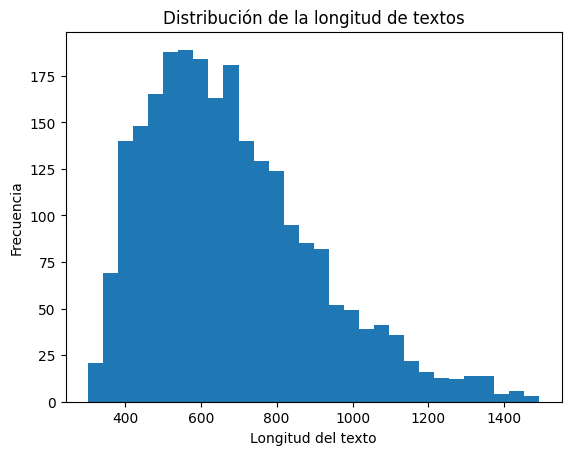

In [9]:
df["longitud"] = df["textos"].str.len()
plt.hist(df["longitud"], bins=30)
plt.xlabel("Longitud del texto")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de textos")
plt.show()

In [10]:
min_len = df["textos"].str.len().min()
print("Longitud mínima encontrada:", min_len)

texto_mas_corto = df.loc[df["textos"].str.len().idxmin(), "textos"]
print("Texto más corto:", texto_mas_corto)

Longitud mínima encontrada: 303
Texto más corto: En 2014, Bután fue testigo del mayor número de casos de drogas jamás registrado por las autoridades (644 casos). La gran mayoría (90%) estaban relacionados con la posesión de sustancias controladas. El cannabis, que además de cultivarse también crecía en estado salvaje, fue la droga de abuso más común.


La opinión más corta de los datos de prueba es de 303 caracteres. Según [help.imbd.com](https://help.imdb.com/article/contribution/contribution-information/user-review-guidelines/GABTWSNLDNFLPRRH?utm_source=chatgpt.com#) "La longitud mínima de las reseñas es de 300 caracteres para garantizar el mayor valor para nuestros usuarios". En este caso no hay opiniones con menos de 300 caracteres, pero en un futuro si puede que hallan, por lo que se filtran:

In [11]:
df_filtrado = df[df["textos"].str.len() >= 300]

## 2.5. Limpieza del Texto:


In [12]:
def limpiar_texto(texto):
    # 1. Minúsculas
    texto = texto.lower()
    
    # 2. Eliminar puntuación, números y caracteres especiales
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    
    # 3. Tokenización
    tokens = word_tokenize(texto, language="spanish")
    
    # 4. Eliminar stopwords
    stop_words = set(stopwords.words("spanish"))
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Normalización (ejemplo con stemming)
    stemmer = SnowballStemmer("spanish")
    tokens = [stemmer.stem(word) for word in tokens]
    
    # lematización:
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


In [13]:
t_wiki = "En 2014, Bután fue testigo del mayor número de casos de drogas jamás registrado por las autoridades (644 casos). La gran mayoría (90%) estaban relacionados con la posesión de sustancias controladas. El cannabis, que además de cultivarse también crecía en estado salvaje, fue la droga de abuso más común."
limpiar_texto(t_wiki)

'butan testig mayor numer ca drog jamas registr autor ca gran mayor relacion posesion sustanci control cannabis ademas cultiv crec salvaj drog abus comun'

In [14]:
df_filtrado["texto_limpio"] = df_filtrado["textos"].apply(limpiar_texto)
df_filtrado.head()

,textos,labels,longitud,texto_limpio
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,aprendizaj educ consider sinon escolariz forma...
1,Para los niños más pequeños (bebés y niños peq...,4,516,niñ pequeñ bebes niñ pequeñ capacit especializ...
2,"Además, la formación de especialistas en medic...",3,659,ademas formacion especial medicin general incl...
3,En los países de la OCDE se tiende a pasar de ...,4,693,pais ocde tiend pa cur obligatori optat abiert...
4,Este grupo se centró en las personas que padec...,3,608,grup centr person padec trastorn mental comorb...


Se eliminan columnas que ya no se usan:

In [15]:
df_filtrado.drop(columns=["longitud", "textos"], inplace=True)

Se dividen los datos con una proporción de 70% para entrenar y 30% para probar:

In [16]:
# Variables
X = df_filtrado["texto_limpio"]
y = df_filtrado["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


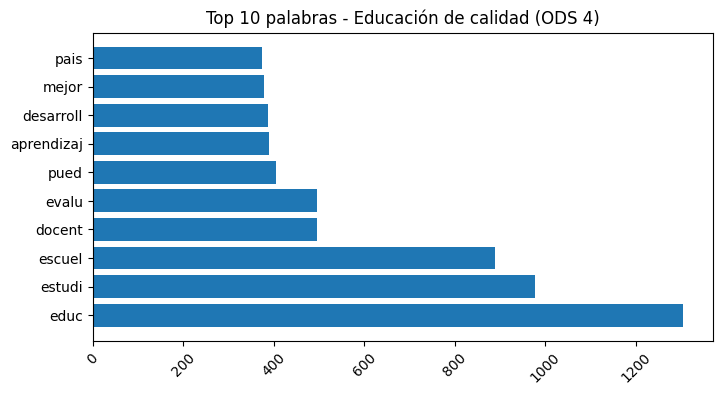

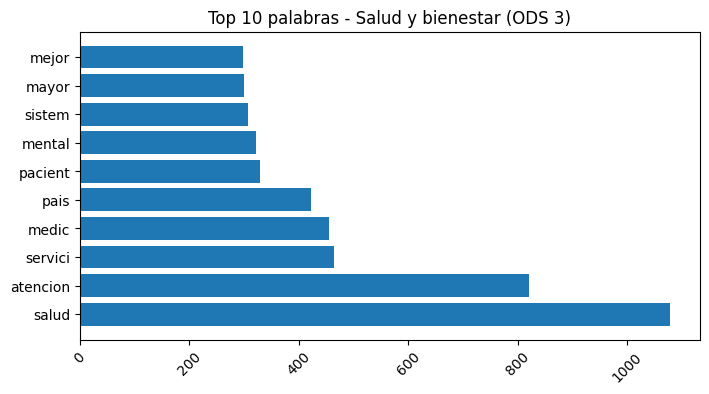

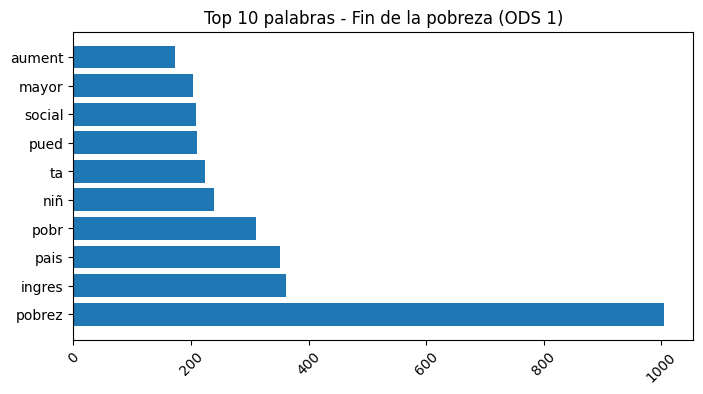

In [39]:
def top_palabras_por_categoria(df, categoria, top_n=10):
    # Filtrar por categoría
    subset = df[df["labels"] == categoria]
    
    # Unir todo el texto
    texto = " ".join(subset["texto_limpio"].astype(str))
    
    # Contar palabras
    counter = Counter(texto.split())
    return counter.most_common(top_n)

# Graficar top palabras para cada categoría
categorias = df_filtrado["labels"].unique()

for cat in categorias:
    top_words = top_palabras_por_categoria(df_filtrado, cat, 10)
    palabras, frec = zip(*top_words)
    
    plt.figure(figsize=(8,4))
    plt.barh(palabras, frec)
    plt.title(f"Top 10 palabras - {dict_ods[cat]} (ODS {cat})")
    plt.xticks(rotation=45)
    plt.show()


In [18]:
# vectorizer = TfidfVectorizer()

# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)


# 3. Modelado y evaluación

## 3.1 ...

## 3.2 Función para mostrar la matriz de confusión

In [21]:
def plot_confusion_matrix(y_true, y_pred, clases, titulo="Matriz de Confusión"):
    """
    Dibuja una matriz de confusión bonita con seaborn.
    
    Parámetros:
    - y_true: etiquetas reales
    - y_pred: etiquetas predichas
    - clases: lista con nombres de las clases (ej. ["Negativa", "Positiva"])
    - titulo: título del gráfico
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(titulo)
    plt.show()
    
def run_model_(model, param_grid, title):
    pipeline = Pipeline([
        ('clf', model)
    ])

    grid_search = GridSearchCV(
    pipeline,
    param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    print("Mejor modelo:", grid_search.best_estimator_)
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor f1_macro en CV:", grid_search.best_score_)

    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, clases=[dict_ods[i] for i in sorted(dict_ods.keys())], titulo=title)
    pass

def run_model(model, param_grid, title):
    pipeline = Pipeline([
        ("vect", TfidfVectorizer()),
        ('clf', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring='f1_macro'
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print("="*60)
    print(" Mejor modelo:", best_model)
    print(" Mejores parámetros:", grid_search.best_params_)
    print(" Mejor f1_macro en CV:", grid_search.best_score_)
    print("="*60)

    y_pred = best_model.predict(X_test)

    print("\n Evaluación en conjunto de test:")
    print(f"Accuracy:              {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (Macro):     {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Precision (Weighted):  {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (Macro):        {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (Weighted):     {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 (Macro):            {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1 (Weighted):         {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\n Reporte por clase:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(
        y_test, y_pred,
        clases=[dict_ods[i] for i in sorted(dict_ods.keys())],
        titulo=title
    )

    return best_model

## 3.3 Modelos

### 3.3.1 Multinomial Naive Bayes

Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB(alpha=0.1))])
 Mejores parámetros: {'clf__alpha': 0.1}
 Mejor f1_macro en CV: 0.9600293222517715

 Evaluación en conjunto de test:
Accuracy:              0.9521
Precision (Macro):     0.9507
Precision (Weighted):  0.9521
Recall (Macro):        0.9439
Recall (Weighted):     0.9521
F1 (Macro):            0.9471
F1 (Weighted):         0.9519

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.94      0.90      0.92       126
           3       0.96      0.95      0.95       224
           4       0.95      0.98      0.97       256

    accuracy                           0.95       606
   macro avg       0.95      0.94      0.95       606
weighted avg       0.95      0.95      0.95       606



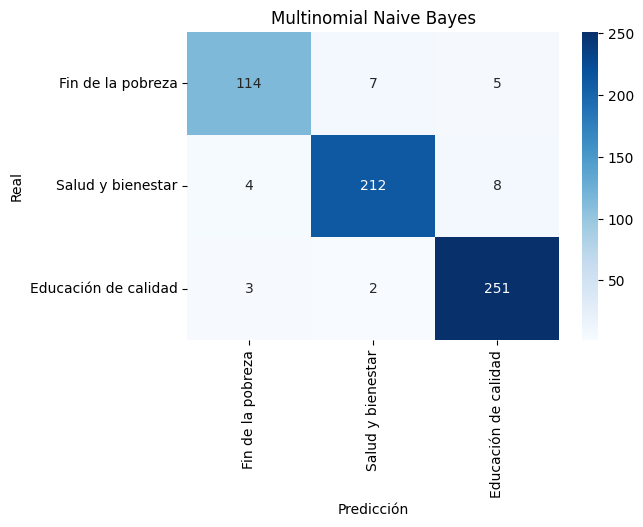

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [22]:
model = MultinomialNB()
param_grid = {
    "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
}
run_model(model, param_grid, "Multinomial Naive Bayes")

### 3.3.2 Logistic Regresion (Juan Hernández)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=42))])
 Mejores parámetros: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
 Mejor f1_macro en CV: 0.9779553070912854

 Evaluación en conjunto de test:
Accuracy:              0.9736
Precision (Macro):     0.9696
Precision (Weighted):  0.9737
Recall (Macro):        0.9688
Recall (Weighted):     0.9736
F1 (Macro):            0.9692
F1 (Weighted):         0.9736

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       126
           3       0.96      0.98      0.97       224
           4       0.99      0.98      0.99       256

    accuracy                           0.97       606
   macro avg       0.97      0.97      0.97     

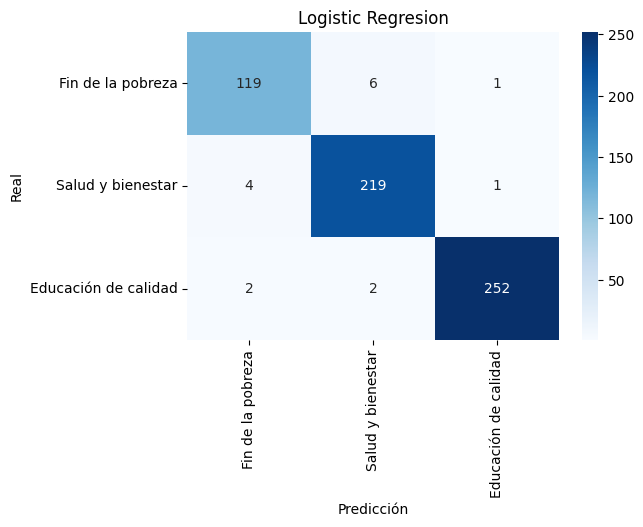

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [23]:
model = LogisticRegression(max_iter=1000, random_state=42)
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "Logistic Regresion")

### 3.3.3 Desicion Tree

Fitting 5 folds for each of 48 candidates, totalling 240 fits
 Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=20,
                                        random_state=42))])
 Mejores parámetros: {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1}
 Mejor f1_macro en CV: 0.9242997580630595

 Evaluación en conjunto de test:
Accuracy:              0.8779
Precision (Macro):     0.8688
Precision (Weighted):  0.8776
Recall (Macro):        0.8660
Recall (Weighted):     0.8779
F1 (Macro):            0.8674
F1 (Weighted):         0.8777

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.83      0.81      0.82       126
           3       0.86      0.87      0.87       224
           4       0.91      0.92      0.92       256

    accuracy                           0.88       606
   ma

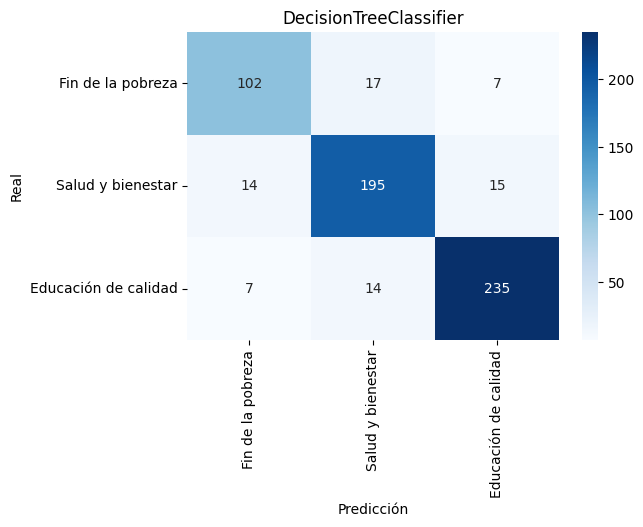

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [24]:
model = DecisionTreeClassifier(random_state=42)
param_grid = {
    "clf__max_depth": [5, 10, 20, None],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__criterion": ["gini", "entropy"],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "DecisionTreeClassifier")

### 3.3.4 KNN (Jerónimo Pineda)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 KNeighborsClassifier(n_neighbors=10, weights='distance'))])
 Mejores parámetros: {'clf__n_neighbors': 10, 'clf__weights': 'distance'}
 Mejor f1_macro en CV: 0.9583491610670019

 Evaluación en conjunto de test:
Accuracy:              0.9472
Precision (Macro):     0.9438
Precision (Weighted):  0.9482
Recall (Macro):        0.9408
Recall (Weighted):     0.9472
F1 (Macro):            0.9419
F1 (Weighted):         0.9472

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.91      0.91      0.91       126
           3       0.99      0.93      0.96       224
           4       0.93      0.98      0.95       256

    accuracy                           0.95       606
   macro avg       0.94      0.94      0.94       606
weighted avg       0.95      0.95      0.95       606



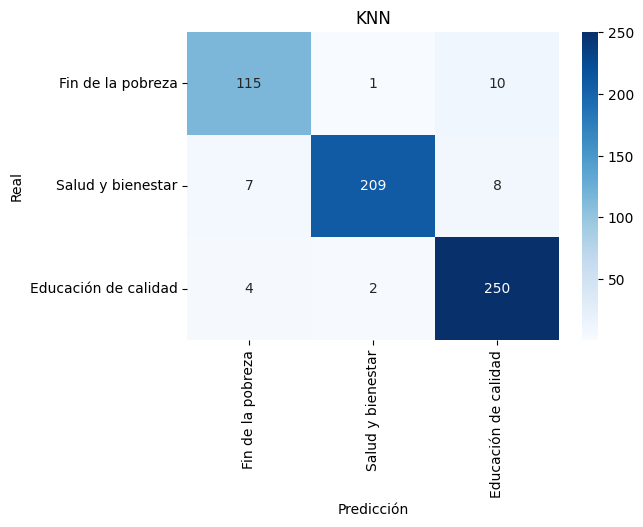

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [25]:
model = KNeighborsClassifier()
param_grid = {
    "clf__n_neighbors": [1,2,3,4,3, 5, 10, 15],
    "clf__weights": ["uniform", "distance"]
}
run_model(model, param_grid, "KNN")

### 3.3.5 Random Forest (David)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
 Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])
 Mejores parámetros: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
 Mejor f1_macro en CV: 0.9692913326329851

 Evaluación en conjunto de test:
Accuracy:              0.9505
Precision (Macro):     0.9497
Precision (Weighted):  0.9506
Recall (Macro):        0.9405
Recall (Weighted):     0.9505
F1 (Macro):            0.9447
F1 (Weighted):         0.9503

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.95      0.89      0.92       126
           3       0.93      0.96      0.95       224
           4       0.97      0.97      0.97       256

    accuracy                           0.95       606

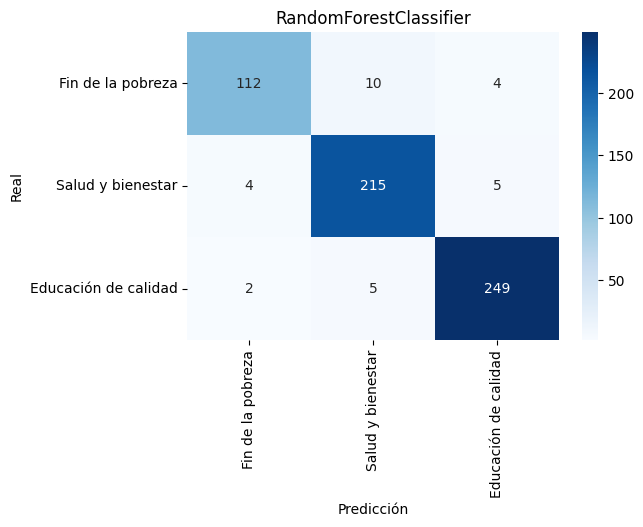

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [26]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_leaf": [1, 5],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "RandomForestClassifier")

### 3.3.6 Linear SVC (Juan Hernández)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LinearSVC(C=1, class_weight='balanced', random_state=42))])
 Mejores parámetros: {'clf__C': 1, 'clf__class_weight': 'balanced'}
 Mejor f1_macro en CV: 0.9796981886367518

 Evaluación en conjunto de test:
Accuracy:              0.9670
Precision (Macro):     0.9638
Precision (Weighted):  0.9670
Recall (Macro):        0.9594
Recall (Weighted):     0.9670
F1 (Macro):            0.9615
F1 (Weighted):         0.9669

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.95      0.92      0.94       126
           3       0.96      0.97      0.96       224
           4       0.98      0.98      0.98       256

    accuracy                           0.97       606
   macro avg       0.96      0.96      0.96       606
weighted avg       0.97      0.97      0.97       606



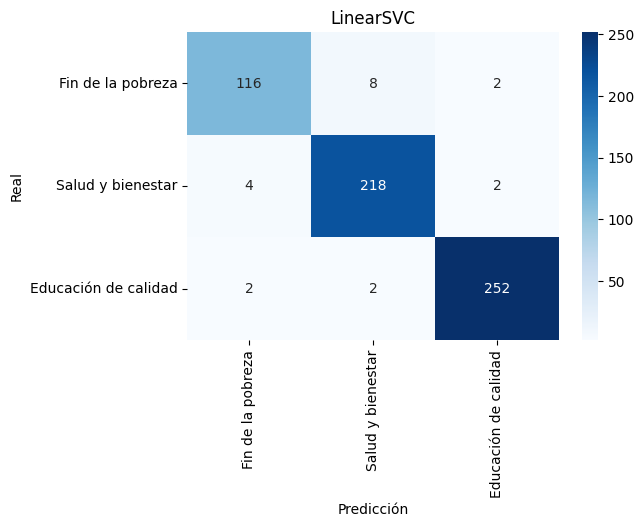

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [27]:
model = LinearSVC(random_state=42)
param_grid = {
    "clf__C": [0.01, 0.1, 0.9, 1, 1.1, 10],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "LinearSVC")

## 3.4 Seleccionar mejor modelo

In [28]:
# Diccionario de modelos y parámetros
param_grid = [

    # Multinomial Naive Bayes
    {
        "clf": [MultinomialNB()],
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    },

    # Logistic Regression
    {
        "clf": [LogisticRegression(max_iter=1000, random_state=42)],
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__class_weight": [None, "balanced"]
    },

    # Decision Tree
    {
        "clf": [DecisionTreeClassifier(random_state=42)],
        "clf__max_depth": [5, 10, 20, None],
        "clf__min_samples_leaf": [1, 5, 10],
        "clf__criterion": ["gini", "entropy"],
        "clf__class_weight": [None, "balanced"]
    },

    # KNN
    {
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": [1,2,3,4,3, 5, 10, 15],
        "clf__weights": ["uniform", "distance"]
    },

    # Random Forest
    {
        "clf": [RandomForestClassifier(random_state=42)],
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [10, 20, None],
        "clf__min_samples_leaf": [1, 5],
        "clf__class_weight": [None, "balanced"]
    },

    # SVM Lineal
    {
        "clf": [LinearSVC(random_state=42)],
        "clf__C": [0.01, 0.1, 0.9, 1, 1.1, 10],
        "clf__class_weight": [None, "balanced"]
    }
]


pipeline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", MultinomialNB())  # Placeholder
])

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar sobre tus vectores ya listos
grid.fit(X_train, y_train)

print("Mejor modelo:", grid.best_estimator_)
print("Mejores parámetros:", grid.best_params_)
print("Mejor f1_macro en CV:", grid.best_score_)

Fitting 5 folds for each of 113 candidates, totalling 565 fits
Mejor modelo: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LinearSVC(C=1, class_weight='balanced', random_state=42))])
Mejores parámetros: {'clf': LinearSVC(random_state=42), 'clf__C': 1, 'clf__class_weight': 'balanced'}
Mejor f1_macro en CV: 0.9796981886367518


In [32]:
results = pd.DataFrame(grid.cv_results_)

# Ordenar por la métrica (mean_test_score)
top10 = results.sort_values(by="mean_test_score", ascending=False).head(10)

# Mostrar solo columnas relevantes
print("\nTop 10 modelos:")
top10[[
    "rank_test_score",
    "mean_test_score",
    "std_test_score",
    "params"
]]

# top10


Top 10 modelos:


,rank_test_score,mean_test_score,std_test_score,params
108,1,0.979698,0.004414,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
110,2,0.979495,0.004391,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
106,3,0.979239,0.004564,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
109,4,0.978368,0.004514,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
12,5,0.977955,0.003863,"{'clf': LogisticRegression(max_iter=1000, rand..."
107,6,0.977903,0.004573,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
105,7,0.976512,0.006810,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
111,8,0.976133,0.004007,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
112,8,0.976133,0.004007,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
10,10,0.976077,0.006991,"{'clf': LogisticRegression(max_iter=1000, rand..."


In [34]:
best_model = grid.best_estimator_

# Predicciones sobre train y test
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
f1_cv = grid.best_score_

print("==== Mejor modelo ====")
print(best_model)
print("\nMejores parámetros:")
print(grid.best_params_)
print("\nF1-macro (train):", f1_train)
print("F1-macro (CV):", f1_cv)
print("F1-macro (test):", f1_test)


==== Mejor modelo ====
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LinearSVC(C=1, class_weight='balanced', random_state=42))])

Mejores parámetros:
{'clf': LinearSVC(random_state=42), 'clf__C': 1, 'clf__class_weight': 'balanced'}

F1-macro (train): 1.0
F1-macro (CV): 0.9796981886367518
F1-macro (test): 0.9614868802930822


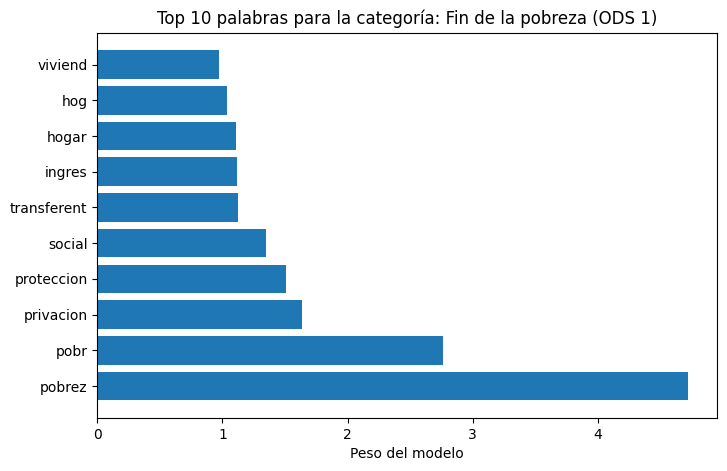

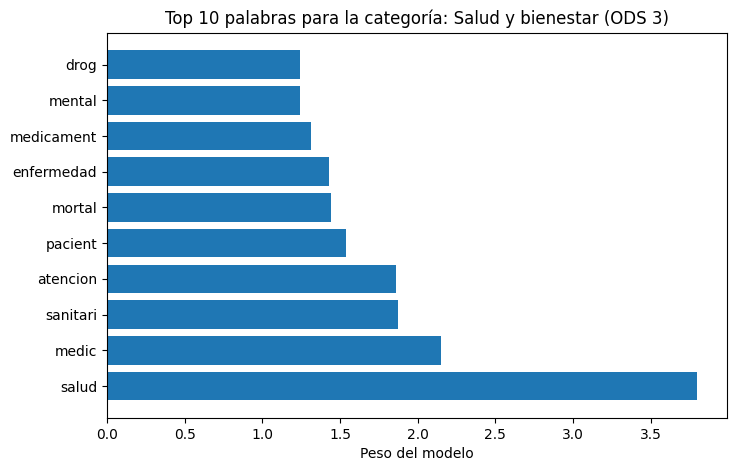

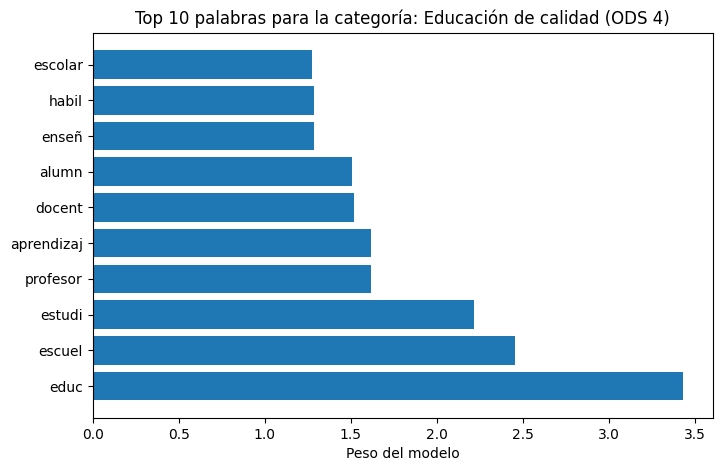

In [38]:
if hasattr(best_model.named_steps['clf'], 'coef_'):
    clf = best_model.named_steps['clf']
    vect = best_model.named_steps['vect']
    feature_names = vect.get_feature_names_out()
    
    # Iterar sobre cada clase
    classes = clf.classes_
    for i, cat in enumerate(classes):
        coefs = clf.coef_[i]
        top_n = 10
        top_idx = np.argsort(coefs)[-top_n:]  # top palabras positivas
        top_features = feature_names[top_idx]
        top_coefs = coefs[top_idx]

        # Graficar
        plt.figure(figsize=(8,5))
        plt.barh(top_features[::-1], top_coefs[::-1])
        plt.xlabel("Peso del modelo")
        plt.title(f"Top {top_n} palabras para la categoría: {dict_ods[cat]} (ODS {cat})")
        plt.show()
else:
    print("NO")